# livelossplot example: PyTorch

Last update: `livelossplot 0.5.0`. For code and documentation, see [livelossplot GitHub repository](https://github.com/stared/livelossplot).

<a href="https://colab.research.google.com/github/stared/livelossplot/blob/master/examples/pytorch.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

In [30]:
!pip install livelossplot --quiet

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses

In [32]:
base_string = "()()" + (32 - 4) * " "

def shuffle_string(s):
    indices = np.arange(len(s), dtype='uint8')
    np.random.shuffle(indices)
    return "".join(base_string[i] for i in indices)

def is_correct(seq):
    open_brackets = 0
    val = {"(": 1, " ": 0, ")": -1}
    for c in seq:
        open_brackets += val[c]
        if open_brackets < 0:
            return False
    return open_brackets == 0

char2id = {" ": 0, "(": 1, ")": 2}

def generate_pairs(size):
    X = np.zeros((size, 3, len(base_string)), dtype='float32')
    Y = np.zeros((size), dtype='int64')
    for i in range(size):
        s = shuffle_string(base_string)
        Y[i] = int(is_correct(s))
        for j, c in enumerate(s):
            X[i, char2id[c], j] = 1.
    return X, Y

def generate_train_test_pairs(size):
    X, Y = generate_pairs(size)
    return train_test_split(X, Y, test_size=0.25, random_state=42)

In [33]:
x = shuffle_string(base_string)
print(x, "- correct" if is_correct(x) else "- incorrect")

  ()      ) (                    - incorrect


In [34]:
X_train, X_test, Y_train, Y_test = generate_train_test_pairs(1000)

trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)),
                         batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)),
                         batch_size=32, shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [35]:
class Recurrent(nn.Module):
    def __init__(self, rnn_size):
        super(Recurrent, self).__init__()
        self.gru = nn.GRU(input_size=3, hidden_size=rnn_size)
        self.fc = nn.Linear(rnn_size, 2)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        output, hidden = self.gru(x)
        return self.fc(hidden.squeeze(0))

In [39]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    phase = "train"
    
    for epoch in range(num_epochs):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        
        logs['log loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [40]:
model = Recurrent(8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

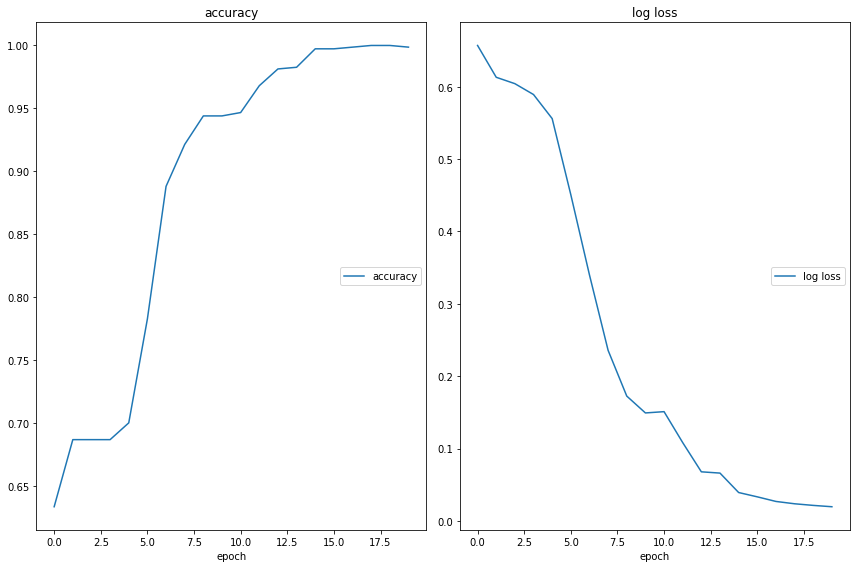

accuracy
	accuracy         	 (min:    0.633, max:    1.000, cur:    0.999)
log loss
	log loss         	 (min:    0.020, max:    0.657, cur:    0.020)


In [41]:
train_model(model, criterion, optimizer, num_epochs=20)